In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [58]:
#Uses gpu if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

batch_size = 16

#Downloads datasets
image_size = (224, 224)
transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
dataset = torchvision.datasets.Imagenette(root='./data', download=True, transform=transform) #Set download to true first time
class_names = dataset.classes

#Split for cross validation
test_size = len(dataset) // 6
train_size = len(dataset) - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#Creates DataLoaders for each set
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [66]:
#Defines class for a residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, halving):
        super().__init__()

        #If halving is true, the feature size is cut in half and the out_channels is doubled
        out_channels = in_channels
        stride1 = 1
        stride2 = 1
        if halving:
            out_channels *= 2
            stride1 = 2

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1), \
                                        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)) if halving else None

    def forward(self, x):
        #Keeps activation from previous layer to add as residual later
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        #Normal convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        #Adds residual
        x += identity
        out = F.relu(x)
        return out


#Defines Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self,):
        super().__init__()

        #Residual/Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=5, stride=2, padding=2)

        self.res1 = ResidualBlock(in_channels=64, kernel_size=3, halving=False)
        self.res2 = ResidualBlock(in_channels=64, kernel_size=3, halving=False)

        self.res3 = ResidualBlock(in_channels=64, kernel_size=3, halving=True)
        self.res4 = ResidualBlock(in_channels=128, kernel_size=3, halving=False)

        self.res5 = ResidualBlock(in_channels=128, kernel_size=3, halving=True)
        self.res6 = ResidualBlock(in_channels=256, kernel_size=3, halving=False)

        self.res7 = ResidualBlock(in_channels=256, kernel_size=3, halving=True)
        self.res8 = ResidualBlock(in_channels=512, kernel_size=3, halving=False)

        self.pool2 = nn.AvgPool2d(kernel_size=7,stride=1)

        #Fully connected layers
        self.flatten = nn.Flatten()
        self.out = nn.Linear(in_features=512, out_features=10)


    def forward(self, x):
        #Residual/Convolutional layers with ReLU activation function
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.res1(x)
        x = self.res2(x)

        x = self.res3(x)
        x = self.res4(x)

        x = self.res5(x)
        x = self.res6(x)

        x = self.res7(x)
        x = self.res8(x)

        x = self.pool2(x)

        #Fully connected layer with ReLU activation
        x = self.flatten(x)
        out = F.relu(self.out(x))
        
        return out

In [67]:
#Iterates through a training epoch while displaying performance metrics by batch
def train_epoch(network, optimizer, criterion):
    network.train(True)
    running_loss = 0.0
    running_accuracy = 0.0

    for batch_index, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = network(inputs)
        num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += num_correct / batch_size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            avg_acc_across_batches = (running_accuracy / 100) * 100
            print('Batch{0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0
            running_accuracy = 0

#Optional method to evaluate performance on validation data
def validate_epoch(network, criterion):
    network.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = network(inputs)
            num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += num_correct / batch_size

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(testloader)
    avg_accuracy_across_batches = (running_accuracy / len(testloader)) * 100
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches, avg_accuracy_across_batches))
    print('*****************************************')
    print()
            

In [68]:
#Sets up CNN, optimizer, and loss function
cnn = CNN()
cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.0001)

#Trains the CNN
num_epochs = 10
for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_epoch(cnn, optimizer, criterion)
    validate_epoch(cnn, criterion)

Epoch 1
Batch100, Loss: 2.278, Accuracy: 13.4%
Batch200, Loss: 2.220, Accuracy: 11.8%
Batch300, Loss: 2.218, Accuracy: 14.6%
Batch400, Loss: 2.180, Accuracy: 14.6%
Val Loss: 2.165, Val Accuracy: 16.7%
*****************************************

Epoch 2
Batch100, Loss: 2.159, Accuracy: 16.1%
Batch200, Loss: 2.152, Accuracy: 17.8%
Batch300, Loss: 2.042, Accuracy: 22.4%
Batch400, Loss: 2.043, Accuracy: 20.0%
Val Loss: 2.105, Val Accuracy: 22.8%
*****************************************

Epoch 3
Batch100, Loss: 2.026, Accuracy: 20.1%
Batch200, Loss: 1.955, Accuracy: 25.1%
Batch300, Loss: 2.004, Accuracy: 21.4%
Batch400, Loss: 1.992, Accuracy: 22.4%
Val Loss: 1.937, Val Accuracy: 24.2%
*****************************************

Epoch 4
Batch100, Loss: 1.916, Accuracy: 23.7%
Batch200, Loss: 2.000, Accuracy: 21.2%
Batch300, Loss: 1.948, Accuracy: 24.1%
Batch400, Loss: 1.899, Accuracy: 27.0%
Val Loss: 1.871, Val Accuracy: 26.0%
*****************************************

Epoch 5
Batch100, Loss: 

In [69]:
#Verifies accuracy on test data set
total_correct = 0
for batch_index, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(inputs)
        total_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
print(f"Accuracy {(total_correct/len(test_dataset)) * 100}")

Accuracy 43.02915082382763


In [63]:
test_iter = iter(testloader)

True label: golf ball
Guess label: tench


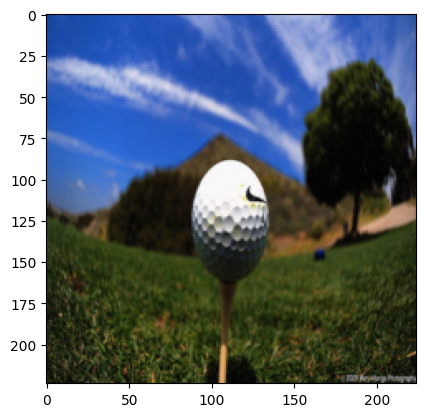

In [64]:
#Shows an image along with a guess and true label
images, true_labels = next(test_iter)
cnn.train(False)
guess_labels = cnn(images.to(device))
np_imgs = images.numpy()
np_img = np_imgs[0]
guess_label = torch.argmax(guess_labels[0]).item()
print(f"True label: {class_names[true_labels[0]][0]}")
print(f"Guess label: {class_names[guess_label][0]}")
plt.imshow(np_img.transpose((1, 2, 0)))